# Mol-2-Vec (NLP) with CATBoost for Partition Coefficient-LogP Predictions 

(2296, 9)
mol2vec shape: (2296, 300)
features shape: (2296, 300)
Learning rate set to 0.045068
0:	learn: 31.5544557	total: 17.5ms	remaining: 17.5s
100:	learn: 7.5756709	total: 705ms	remaining: 6.27s
200:	learn: 4.9247882	total: 1.43s	remaining: 5.7s
300:	learn: 3.6085977	total: 2.15s	remaining: 4.98s
400:	learn: 2.8154157	total: 2.86s	remaining: 4.27s
500:	learn: 2.2850579	total: 3.57s	remaining: 3.55s
600:	learn: 1.8984128	total: 4.32s	remaining: 2.86s
700:	learn: 1.6090495	total: 5.22s	remaining: 2.23s
800:	learn: 1.3840777	total: 6.15s	remaining: 1.53s
900:	learn: 1.2029642	total: 7.07s	remaining: 777ms
999:	learn: 1.0542846	total: 7.99s	remaining: 0us
Test MAE: 3.6368632798887357
Test RMSE: 5.861055611446567
Test R2: 0.9685467932152354


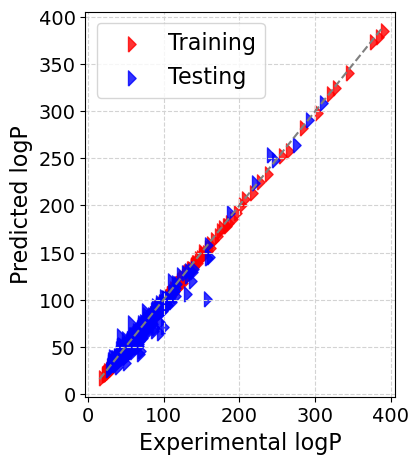

In [ ]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from gensim.models import word2vec
from sklearn import preprocessing
from catboost import CatBoostRegressor

# Reading organic solvents viscosity data

input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Mol2vec/VOC/'
dataset = pd.read_csv(input_dir + 'VOC-Database.csv')

# Sorting dataset with unique SMILES
dataset = dataset.drop_duplicates(subset=['SMILES']).sort_values(by='SMILES')

print(dataset.shape)

mol_smiles = dataset['SMILES']
enthalpy_vap = dataset['dvap']

# Load the pre-trained Word2Vec model
model_path = 'D:/Postdoc-Work/Results/ML_Codes/Scikit-Learn_ML/Models_MM/Organic-Solvents_Viscosity/mol2vec-master/examples/models/model_300dim.pkl'
model = word2vec.Word2Vec.load(model_path)

# Extraction of identifiers from molecules
os_smiles = [Chem.MolFromSmiles(x) for x in mol_smiles]
os_sentences = [mol2alt_sentence(x, 1) for x in os_smiles]

# Define the DfVec class if not already defined
class DfVec:
    def __init__(self, vector):
        self.vector = vector

def sentences2vec(sentences, model, unseen='UNK'):
    vectors = []
    for sentence in sentences:
        vec = []
        for word in sentence:
            if word in model.wv.key_to_index:
                vec.append(model.wv[word])
            else:
                if unseen in model.wv.key_to_index:
                    vec.append(model.wv[unseen])
                else:
                    vec.append(np.zeros(model.vector_size))
        vectors.append(np.sum(vec, axis=0))
    return vectors

# Convert sentences to vectors
os_mol2vec = [DfVec(x) for x in sentences2vec(os_sentences, model, unseen='UNK')]

# Use the correct attribute name 'vector' instead of 'vec'
np_os_mol2vec = np.array([x.vector for x in os_mol2vec])
print("mol2vec shape:", np_os_mol2vec.shape)

# Standardize the mol2vec features
scaler = preprocessing.StandardScaler()
np_os_mol2vec = scaler.fit_transform(np_os_mol2vec)

print("features shape:", np_os_mol2vec.shape)

# Save the input features and target variable
input_features_df = pd.DataFrame(np_os_mol2vec, columns=[f'feature_{i}' for i in range(np_os_mol2vec.shape[1])])
input_features_df['enthalpy_vap'] = enthalpy_vap.values
input_features_df.to_csv('input_features_vap-enthalpy.csv', index=False)



# Simple train-test split
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    np_os_mol2vec, enthalpy_vap, mol_smiles, test_size=0.2, random_state=536)

# Train CatBoost
cat_model = CatBoostRegressor(verbose=100)
cat_model.fit(X_train, y_train)

# Predict on train
y_pred_train = cat_model.predict(X_train)
train_df = pd.DataFrame({
    'SMILES': smiles_train.reset_index(drop=True),
    'enthalpy_vap_actual': y_train.reset_index(drop=True),
    'enthalpy_vap_pred': y_pred_train
})
train_df.to_csv('CATBoost_Mol2vec-Training_Enthalpy-Vap-RS536.csv', index=False)

# Predict on test
y_pred_test = cat_model.predict(X_test)
test_df = pd.DataFrame({
    'SMILES': smiles_test.reset_index(drop=True),
    'enthalpy_vap_actual': y_test.reset_index(drop=True),
    'enthalpy_vap_pred': y_pred_test
})
test_df.to_csv('CATBoost_Mol2vec-Testing_Enthalpy-Vap-RS536.csv', index=False)

# Print metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))

# Scatterplot
plt.figure(figsize=(4, 5))
ln = np.arange(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 0.2)
plt.plot(ln, ln, 'gray', linestyle='--')

plt.scatter(y_train, y_pred_train, color='red', label='Training', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)
plt.scatter(y_test, y_pred_test, color='blue', label='Testing', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)

plt.xlabel('Experimental logP', fontsize=16)
plt.ylabel('Predicted logP', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='#D3D3D3', linestyle='--', which='both', axis='both')
plt.legend(loc='upper left', fontsize=16)
# plt.savefig('CATBoost_Mol2vec-Testing_Enthalpy-Vap_RS536.png', dpi=1200, bbox_inches='tight')
plt.show()


